## AlexNet
* [original paper](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

### Loading data

In [1]:
## trying it on flowers dataset
## good dataset loader: https://github.com/tflearn/tflearn/tree/master/tflearn/datasets
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(227, 227))

(1360, 227, 227, 3)
(1360, 17)


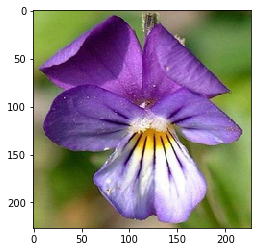

In [2]:
print X.shape # 227x227
print Y.shape # 17 classes

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np

plt.imshow(X[30])

In [3]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

## Setup

In [4]:
import tensorflow as tf

tf.flags.DEFINE_float("learning_rate",  0.0001, "LR")
# tf.flags.DEFINE_float("momentum",  0.9, "momentum")
tf.flags.DEFINE_integer("training_iters", 1000, "Training iterations")
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size")
tf.flags.DEFINE_integer("display_step", 64, "Display Step")
tf.flags.DEFINE_integer("image_size", 227, "Image length or height")
tf.flags.DEFINE_integer("num_classes", 17, "# classes")

FLAGS = tf.flags.FLAGS

## AlexNet

In [5]:
class AlexNet():
    def __init__(self):
        ## (?, 227, 227, 3)
        self.input_x = tf.placeholder(tf.float32, [None, FLAGS.image_size, FLAGS.image_size, 3])
        self.input_y = tf.placeholder(tf.float32, [None, FLAGS.num_classes])
        
        ## 1. conv layer
        ## (?, 57, 57, 96)
        self.conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(self.input_x, \
                                                            filter=tf.Variable(tf.random_normal([11, 11, 3, 96])),
                                                            strides=[1,4,4,1], padding='SAME'),
                                               tf.Variable(tf.random_normal([96])))) 
        ## (?, 29, 29, 96)
        self.maxpool1 = tf.nn.max_pool(self.conv1, ksize=[1, 3, 3, 1], \
                                       strides=[1, 2, 2, 1], padding='SAME')
        self.localnorm1 = tf.nn.local_response_normalization(self.maxpool1)
        
        ## 2. conv layer
        ## (?, 29, 29, 256)
        self.conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(self.localnorm1, \
                                                            filter=tf.Variable(tf.random_normal([5, 5, 96, 256])),
                                                            strides=[1,1,1,1], padding='SAME'),
                                               tf.Variable(tf.random_normal([256])))) 
        ## (?, 15, 15, 96)
        self.maxpool2 = tf.nn.max_pool(self.conv2, ksize=[1, 3, 3, 1], \
                                       strides=[1, 2, 2, 1], padding='SAME')
        self.localnorm2 = tf.nn.local_response_normalization(self.maxpool2)
        
        ## 3. convs 
        self.conv3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(self.localnorm2, \
                                                            filter=tf.Variable(tf.random_normal([3, 3, 256, 384])),
                                                            strides=[1,1,1,1], padding='SAME'),
                                               tf.Variable(tf.random_normal([384])))) 
        self.conv4 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(self.conv3, \
                                                            filter=tf.Variable(tf.random_normal([3, 3, 384, 384])),
                                                            strides=[1,1,1,1], padding='SAME'),
                                               tf.Variable(tf.random_normal([384])))) 
        self.conv5 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(self.conv4, \
                                                            filter=tf.Variable(tf.random_normal([3, 3, 384, 256])),
                                                            strides=[1,1,1,1], padding='SAME'),
                                               tf.Variable(tf.random_normal([256])))) 
        ## (?, 8, 8, 256)
        self.maxpool3 = tf.nn.max_pool(self.conv5, ksize=[1, 3, 3, 1], \
                                       strides=[1, 2, 2, 1], padding='SAME')
        self.localnorm3 = tf.nn.local_response_normalization(self.maxpool3)
        
        ## 4. dense
        ## (?, 16384)
        self.norm3_input = tf.reshape(self.localnorm3, [-1, 8*8*256])
        ## (?, 4096)
        self.dense1 = tf.tanh(tf.matmul(self.norm3_input, tf.Variable(tf.random_normal([8*8*256, 4096])))\
                                 + tf.Variable(tf.random_normal([4096]))) ## to do: add dropout here
        self.dense2 = tf.tanh(tf.matmul(self.dense1, tf.Variable(tf.random_normal([4096, 4096])))\
                                 + tf.Variable(tf.random_normal([4096]))) ## to do: add dropout here
        ## (?, 17)
        self.score = tf.matmul(self.dense2, tf.Variable(tf.random_normal([4096, FLAGS.num_classes])))\
                                 + tf.Variable(tf.random_normal([FLAGS.num_classes]))

        ## logistics
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.score, labels=self.input_y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate).minimize(self.cost)
        self.correct_pred = tf.equal(tf.argmax(self.score,1), tf.argmax(self.input_y,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

In [6]:
tf.reset_default_graph()

ANet = AlexNet()
global_step = tf.Variable(0, name="global_step", trainable=False)
incr_global_step_op = tf.assign(global_step, global_step+1)

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [ ]:
batches = batch_iter(
    list(zip(X, Y)), FLAGS.batch_size, FLAGS.training_iters)


for batch in batches:
    x_batch, y_batch = zip(*batch)
    _, curr_step, curr_cost, curr_accuracy = sess.run([ANet.optimizer, incr_global_step_op, ANet.cost, ANet.accuracy],\
                                  feed_dict={ANet.input_x: x_batch, ANet.input_y: y_batch})
    if curr_step % 1 == 0:
        print "step %d: cost - %.3f \t accuracy - %.3f" % (curr_step, curr_cost, curr_accuracy)

step 37: cost - 53.174 	 accuracy - 0.094
step 38: cost - 46.602 	 accuracy - 0.125
step 39: cost - 53.253 	 accuracy - 0.109
step 40: cost - 45.398 	 accuracy - 0.141
step 41: cost - 45.287 	 accuracy - 0.109
step 42: cost - 43.841 	 accuracy - 0.141
step 43: cost - 43.925 	 accuracy - 0.125
step 44: cost - 41.172 	 accuracy - 0.141
